In [11]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import utils
%matplotlib inline

First of all we should upload data from npz file with the map and rod description.

In [5]:
data = np.load('data_ps1.npz')
env = data['environment']
rod = data['rod']

(11, 11, 4)

Let`s research shape of two numpy arrays:
- Shape of environment
- Shape of rod

In [6]:
env.shape

(100, 100)

In [7]:
rod.shape

(11, 11, 4)

#### Task 1.1. 
Let`s visualize the given data. We will present workspace and different rod orientations.

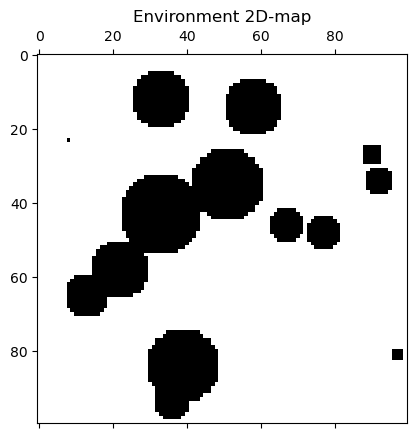

In [27]:
fig, ax = plt.subplots()
ax.matshow(env, cmap='Greys')
plt.title('Environment 2D-map')
plt.show()

Also, can show this map in blue yellow color map.

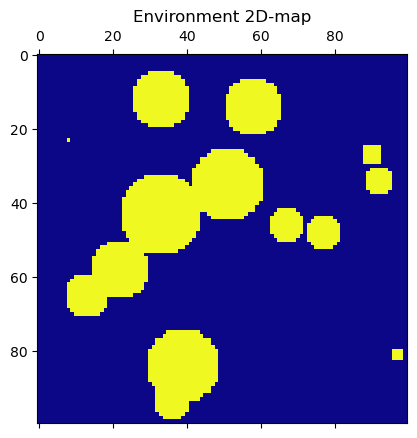

In [28]:
fig, ax = plt.subplots()
ax.matshow(env, cmap='plasma')
plt.title('Environment 2D-map')
plt.show()

Now, let`s show all possible rod configurations.

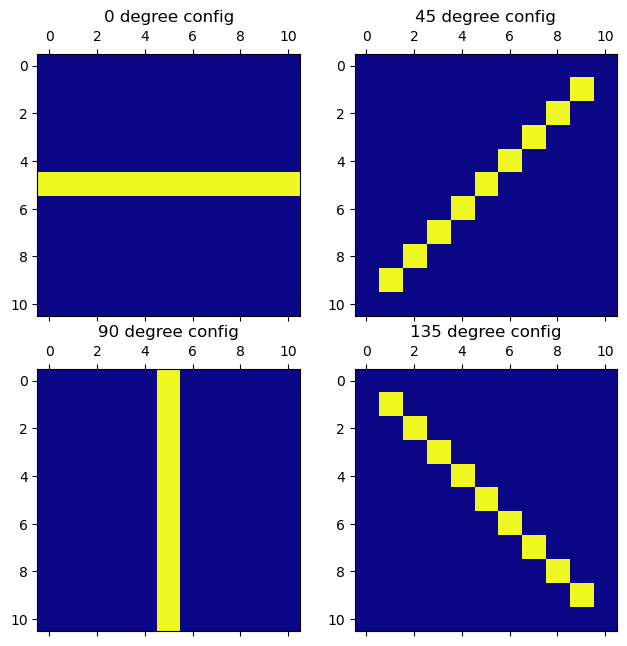

In [39]:
rod0 = rod[:,:,0]
rod1 = rod[:,:,1]
rod2 = rod[:,:,2]
rod3 = rod[:,:,3]

fig, ax = plt.subplots(2, 2, figsize=(7.5, 7.5))
ax[0, 0].matshow(rod0, cmap='plasma')
ax[0, 0].set_title('0 degree config')
ax[0, 1].matshow(rod1, cmap='plasma')
ax[0, 1].set_title('45 degree config')
ax[1, 0].matshow(rod2, cmap='plasma')
ax[1, 0].set_title('90 degree config')
ax[1, 1].matshow(rod3, cmap='plasma')
ax[1, 1].set_title('135 degree config')
plt.show()

Comments: we have four different orientations, which have differs in rotation of 45 degrees. The 0 and 90 degree orientations have length of 11 matrix block, when 45 and 135 degree have 9 blocks on diogonal.

#### Task 1.2.
Let`s visualize environment with the rod object and with right configuration. For this task we will use function plot_enviroment from utils module.

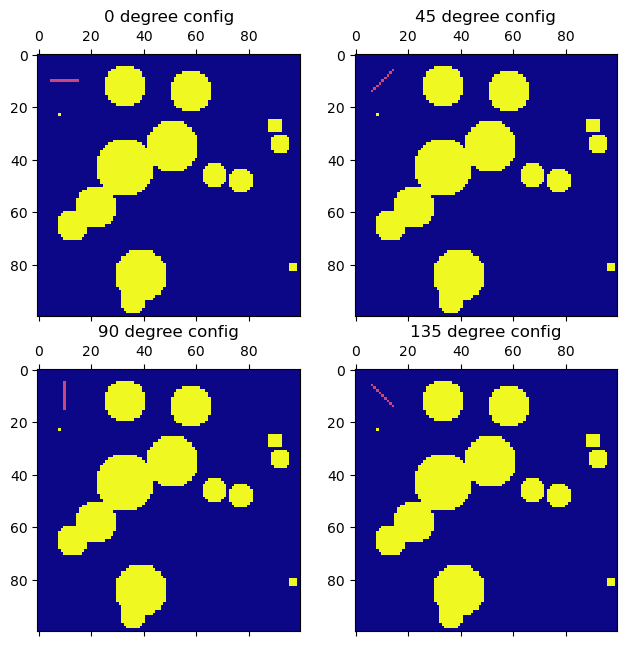

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(7.5, 7.5))

joint_environment0 = utils.plot_enviroment(env, rod, (10, 10, 0))
ax[0, 0].matshow(joint_environment0, cmap='plasma')
ax[0, 0].set_title('0 degree config')
joint_environment1 = utils.plot_enviroment(env, rod, (10, 10, 1))
ax[0, 1].matshow(joint_environment1, cmap='plasma')
ax[0, 1].set_title('45 degree config')
joint_environment2 = utils.plot_enviroment(env, rod, (10, 10, 2))
ax[1, 0].matshow(joint_environment2, cmap='plasma')
ax[1, 0].set_title('90 degree config')
joint_environment3 = utils.plot_enviroment(env, rod, (10, 10, 3))
ax[1, 1].matshow(joint_environment3, cmap='plasma')
ax[1, 1].set_title('135 degree config')

plt.show()

#### Task 1.3.
Now, let's create a configuration space. For this I will use convolve2D function from signal scipy module.

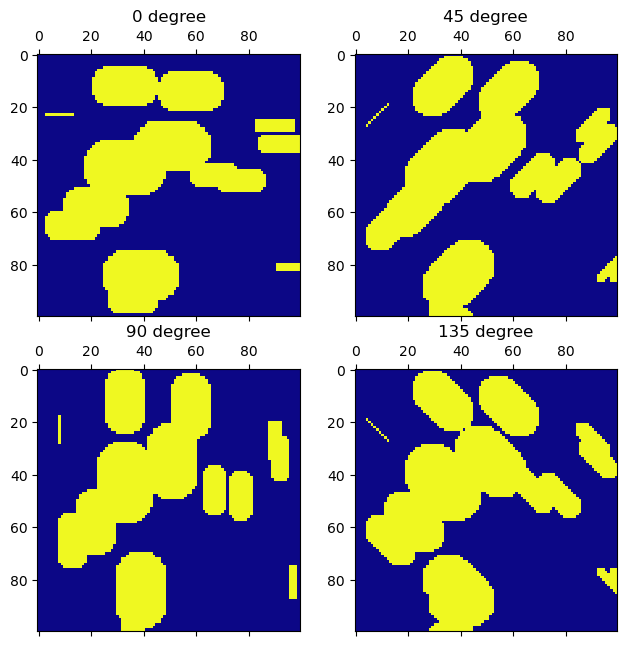

In [50]:
c_space0 = signal.convolve2d(env, rod0, boundary='symm', mode='same')
c_space0 = utils.normalize_image(c_space0)

c_space1 = signal.convolve2d(env, rod1, boundary='symm', mode='same')
c_space1 = utils.normalize_image(c_space1)

c_space2 = signal.convolve2d(env, rod2, boundary='symm', mode='same')
c_space2 = utils.normalize_image(c_space2)

c_space3 = signal.convolve2d(env, rod3, boundary='symm', mode='same')
c_space3 = utils.normalize_image(c_space3)


fig, ax = plt.subplots(2, 2, figsize=(7.5, 7.5))
ax[0, 0].matshow(c_space0, cmap='plasma')
ax[0, 0].set_title('0 degree')
ax[0, 1].matshow(c_space1, cmap='plasma')
ax[0, 1].set_title('45 degree')
ax[1, 0].matshow(c_space2, cmap='plasma')
ax[1, 0].set_title('90 degree')
ax[1, 1].matshow(c_space3, cmap='plasma')
ax[1, 1].set_title('135 degree')
plt.show()

Now let`s join all 4 c-space into one 3-dimencional matrix, which will describe full c-space.

In [52]:
c_space = np.zeros((100, 100, 4))
c_space[:,:,0] = c_space0
c_space[:,:,1] = c_space1
c_space[:,:,2] = c_space2
c_space[:,:,3] = c_space3

c_space.shape

(100, 100, 4)

Let`s check that our c-space is correct.

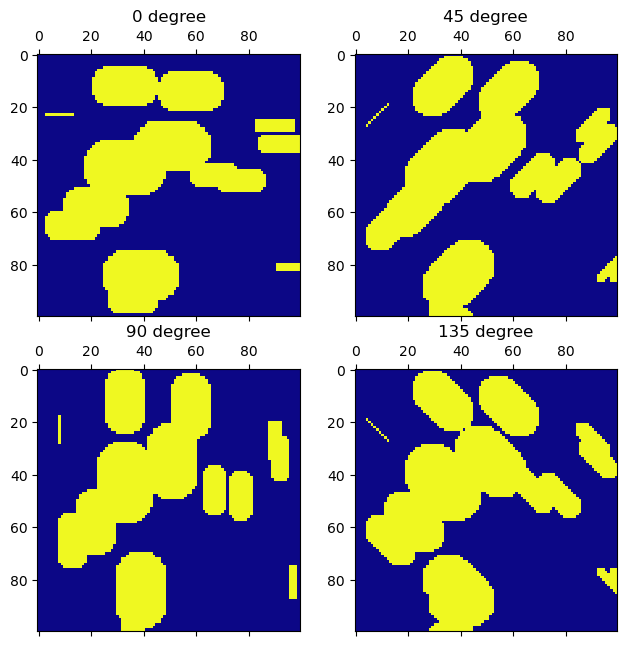

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(7.5, 7.5))
ax[0, 0].matshow(c_space[:,:,0], cmap='plasma')
ax[0, 0].set_title('0 degree')
ax[0, 1].matshow(c_space[:,:,1], cmap='plasma')
ax[0, 1].set_title('45 degree')
ax[1, 0].matshow(c_space[:,:,2], cmap='plasma')
ax[1, 0].set_title('90 degree')
ax[1, 1].matshow(c_space[:,:,3], cmap='plasma')
ax[1, 1].set_title('135 degree')
plt.show()

#### Task 1.4.
Here some comments about our C-space.
Our C-space is 3-dimencional matrix with shape (100, 100, 4). First two coordinates describes point on the plane, third coordinate describe rod orientation. This planes will help with the graph search and planning algorithms:
1. First of all we could describe our rod on the plane with tuple length 3 - $(x, y, \theta)$.
2. Second, we can realise search algorithm checking $(x, y, \theta)$ in C-space - if the point is 0, our robot can move into this position, and movement is forbidden if the point is one. So, we can describe robot movements from one position to another.

#### Task 2.1
Let`s create an A-star algorithm. For this task our heuristic function will be same wuth the Djecstra algorithm: $h\left(q, q_G\right) = 0$

In [86]:
from heapq import heappush, heappop

def up(coord):
    if coord[1] - 1 >= 0 and c_space[coord[0], coord[1] - 1, coord[2]] == 0:
        return (coord[0], coord[1] - 1, coord[2])
    return None

def down(coord):
    if coord[1] + 1 < 100 and c_space[coord[0], coord[1] + 1, coord[2]] == 0:
        return (coord[0], coord[1] + 1, coord[2])
    return None

def right(coord):
    if coord[0] + 1 < 100 and c_space[coord[0] + 1, coord[1], coord[2]] == 0:
        return (coord[0] + 1, coord[1], coord[2])
    return None

def left(coord):
    if coord[0] - 1 >= 0 and c_space[coord[0] - 1, coord[1], coord[2]] == 0:
        return (coord[0] - 1, coord[1], coord[2])
    return None

def rotate_right(coord):
    if c_space[coord[0], coord[1], (coord[2] + 1) % 4] == 0:
        return (coord[0], coord[1], (coord[2] + 1) % 4)
    return None

def rotate_left(coord):
    if c_space[coord[0], coord[1], (coord[2] - 1) % 4] == 0:
        return (coord[0], coord[1], (coord[2] - 1) % 4)
    return None

actions = [up, down, right, left, rotate_left, rotate_right]

plan = []

def a_star(start, finish):
    priority_queue = []
    parent = {}
    cost = {}
    cost[start] = 0
    heappush(priority_queue, (0, start))
    while len(priority_queue) > 0:
        coord = heappop(priority_queue)
        coord = coord[1]
        if coord == finish:
            iter = coord
            plan.clear()
            while iter != start:
                plan.append(iter)
                iter = parent[iter]
            plan.append(start)
            print('Final cost:    ', cost[coord])
            return True
        for act in actions:
            new_coord = act(coord)
            if new_coord is None:
                continue
            if not(new_coord in cost):
                parent[new_coord] = coord
                cost[new_coord] = cost[coord] + 1
                heappush(priority_queue, (cost[new_coord], new_coord))
            else:
                if cost[coord] + 1 < cost[new_coord]:
                    parent[new_coord] = coord
                    cost[new_coord] = cost[coord] + 1
    return False

In [91]:
#I have problem with animation in matplotlib, so I install ffmpeg to solve problems.
#!conda install -c conda-forge ffmpeg

Final cost:     116
117


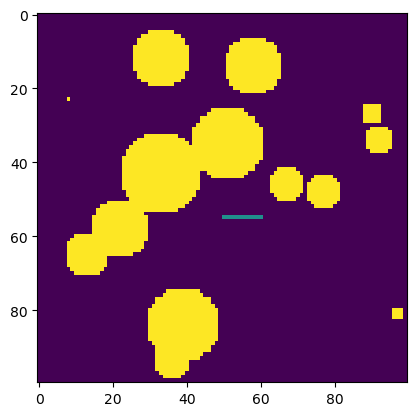

In [87]:
if a_star((6,6,2), (55,55,0)):
    plan.reverse()
    print(len(plan))
    utils.plotting_results(env, rod, plan)

We get our plan with length 117. After watching mp4 file we can see that our robot move correctly.

#### Task 2.2.
Now let's play with heuristic function. We should create replace Dijkstra heuristic function $h\left(q, q_G\right) = 0$ to $L1$  metric.  
First of all, let's improve our $A^{\star}$ algorithm from $A^{\star}\left(x_I, X_G\right)$ to $A^{\star}\left(x_I, X_G, h\left(q, q_G\right)\right)$, where $h\left(q, q_G\right)$ - heuristic function.


In [97]:
def a_star(start, finish, h):
    priority_queue = []
    parent = {}
    cost = {}
    cost[start] = 0
    heappush(priority_queue, (0, start))
    while len(priority_queue) > 0:
        coord = heappop(priority_queue)
        coord = coord[1]
        if coord == finish:
            iter = coord
            plan.clear()
            while iter != start:
                plan.append(iter)
                iter = parent[iter]
            plan.append(start)
            print('Final cost:    ', cost[coord])
            return True
        for act in actions:
            new_coord = act(coord)
            if new_coord is None:
                continue
            if not(new_coord in cost):
                parent[new_coord] = coord
                cost[new_coord] = cost[coord] + 1
                heappush(priority_queue, (cost[new_coord] + h(new_coord, finish), new_coord))
            else:
                if cost[coord] + 1 < cost[new_coord]:
                    parent[new_coord] = coord
                    cost[new_coord] = cost[coord] + 1
    return False

In [98]:
def heuristic_l1(coord, finish):
    return abs(coord[0] - finish[0]) + abs(coord[1] - finish[1])

if a_star((6,6,2), (55,55,0), heuristic_l1):
    plan.reverse()
    print(len(plan))
    

Final cost:     116
117


Comments: we get the same cost from l1 metric and from dijkstra cost. This fact related with the map configuration and metrics. Dijkstra cost increase with any actions, so first we process coordinates for which we spend less actions, so as the l1 metric, which try to reduce the distance between rod and distination point, dijkstra metric also reduce distance because the shortest path have more oportunities to be processed first, because we need less actions to follow the shortest path.

#### Task 2.3.
Let's add orientation in heuristic function $h\left(q, q_G\right)$.

Final cost:     116
117


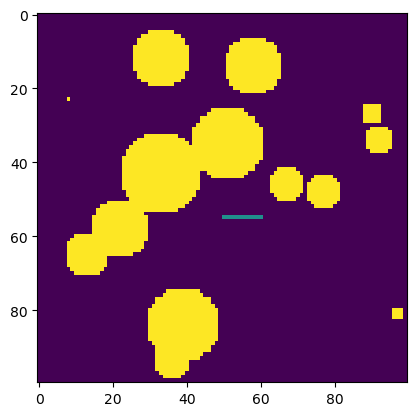

In [113]:
def heuristic_orientation(coord, finish):
    #Our robot is less compact when it has degree 45 or 135, so let's add some additional cost in heuristic when our robot in this states.
    orientation = 0 
    if coord[2] == 1 or coord[2] == 3:
        orientation = 2
    return abs(coord[0] - finish[0]) + abs(coord[1] - finish[1]) + orientation

if a_star((6,6,2), (55,55,0), heuristic_orientation):
    plan.reverse()
    print(len(plan))
    utils.plotting_results(env, rod, plan)

Comments: we have the same results with previous heuristic functions because priority_cost first enqueue cheap movements, which are placed on shortest path because if you are on shortest path you needless actions to reach the goal point. 